# <span style="color:red">QPM: Assignment 8</span>

###  LAFTIT Mehdi, LIN Christine, MUSEUX Célia and YANG Hexuan 

Financial Engineering - Quantitative Portfolio Management

**Due date :** 27/11/2023 9am

## <span style="color:green">Preliminary step</span>

In this assignment, we have to use an estimation window of 120 months. Therefore, to facilitate comparison, the in-sample and out-of-sample performance should be evaluated from January 1977 to December 2020.

In the original papers on volatility timing, volatility is computed using daily returns data. Because we dont have daily data, we estimate current volatility using monthly data for the last 12 months.

We define $ft+1$ to be an excess return

We construct a new volatility-managed factor, whose return is
> $f^σt+1 =c/(σ^2t(f ))× ft+1$

where $σt(f )$ is the previous 12 month’s realized volatility, estimated using monthly data. We choose $c = 1$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tabulate import tabulate

C:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The data file for this assignment has monthly excess returns for nine firm-specific characteristics: 

In [5]:
factor = pd.read_excel('QPM-FactorsData.xlsx')
factor.set_index('Dates', inplace=True)
factor.head()

,Market,SMB,HML,RMW,CMA,UMD,ROE,IA,BAB
Dates,,,,,,,,,
196702,0.0078,0.0334,-0.0217,0.0194,-0.0094,0.0356,0.035317,-0.002064,0.0262
196703,0.0399,0.0163,0.0031,0.0090,-0.0151,0.0142,0.018876,-0.016933,0.0081
196704,0.0389,0.0062,-0.0264,0.0243,-0.0375,0.0064,0.010983,-0.029519,0.0171
196705,-0.0433,0.0198,0.0080,-0.0175,0.0161,0.0067,0.005234,0.024686,0.0201
196706,0.0241,0.0596,0.0096,-0.0064,-0.0239,0.0603,0.002945,-0.021700,-0.0163


We constructing monthly realized variance from monthly data (we estimate current volatility using monthly data for the last 12 months):

In [6]:
var = factor.rolling(window=12).var()

We can plot the variance of the Market factor for instance:

<AxesSubplot:xlabel='Dates'>

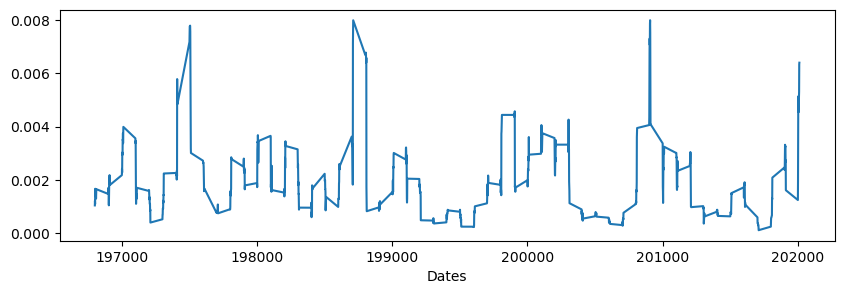

In [7]:
var['Market'].plot(figsize=(10, 3))

We have decided to set c as 1:

In [8]:
c=1

 We use the formula: $f^σt+1 =c/σ^2t(f)× f(t+1)$  to compute volatility managed factor:

In [9]:
volatility_managed_factor = c / var.shift(+1) * factor
volatility_managed_factor = volatility_managed_factor.dropna()
volatility_managed_factor.head()

,Market,SMB,HML,RMW,CMA,UMD,ROE,IA,BAB
Dates,,,,,,,,,
196802,-35.835405,-79.610803,19.666910,-4.044894,30.851335,-42.884860,-12.692406,45.012596,43.503960
196803,1.638609,-20.714932,-10.435006,37.539788,-13.407313,34.671484,73.617569,-16.747000,-32.695174
196804,82.601569,80.350450,-18.097885,87.964436,-43.147938,53.394791,169.289201,-39.417906,2.998469
196805,13.646121,78.785598,16.406748,11.653967,-21.616400,33.507828,62.139523,-36.077366,31.249673
196806,4.765466,-1.776469,13.074556,-43.396924,31.584127,-16.582876,-14.456431,38.254984,119.409491


We got very extreme returns because we chose c = 1.

In order to make original factor dataframe comparable to the new volatility-managed factor dataframe, we decided to start both dataframes from 196802.

In [11]:
factor = factor.loc['196802':]
factor.head()

,Market,SMB,HML,RMW,CMA,UMD,ROE,IA,BAB
Dates,,,,,,,,,
196802,-0.0375,-0.0295,0.0117,-0.0014,0.0249,-0.0341,-0.003786,0.027512,0.0213
196803,0.0020,-0.0128,-0.0059,0.0117,-0.0115,0.0318,0.016762,-0.011343,-0.0158
196804,0.0905,0.0573,-0.0103,0.0279,-0.0366,0.0515,0.037654,-0.026056,0.0017
196805,0.0228,0.0643,0.0084,0.0039,-0.0182,0.0373,0.019600,-0.023165,0.0181
196806,0.0069,-0.0017,0.0067,-0.0133,0.0268,-0.0192,-0.004770,0.024451,0.0689


## <span style="color:green">Question 1 of assignment 8 </span>

We are going to use mean-variance optimization to combine:
- The original (without timing) factor, $ft+1$
- The volatility-managed version of this factor, $f^σt+1$.

In [12]:
# We choose the estimation window T_est = 120 months
T_est = 120

We define the objective function to be minimized:

In [13]:
def objective(weights, gamma, df1, df2, i, j, T_est):
    result = pd.concat([df1.iloc[j:j+T_est, i], df2.iloc[j:j+T_est, i]], axis=1, keys=['Original_' + df1.columns[i], 'Vol_Managed_' + df2.columns[i]])
    mu = result.mean()
    V = result.cov()
    portfolio_return = weights.T @ mu    
    portfolio_risk = weights.T @ V @ weights
    return (gamma/2) * portfolio_risk - portfolio_return

We set the risk aversion, gamma = 5

In [14]:
gamma=5

We combine the orginal factor and vol-managed factor into one portfolio and try to minimize the function defined just above. We do this for each factor and for each rolling window. Therefore, we put it into a double for loop.

In [15]:
weights_df = pd.DataFrame(columns=[f'Factor_{factor.columns[i]}_Weight' for i in range(factor.shape[1])])

for j in range(0, len(factor)-T_est):
    factor_weights = {}  # Dictionary to store weights for each factor
    
    for i in range(factor.shape[1]):
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        initial_weights = np.ones(2)
        additional_args = (gamma, factor, volatility_managed_factor, i, j, T_est)
        result = minimize(objective, initial_weights, method='SLSQP', constraints=constraints, args=additional_args)

        optimal_weights = result.x

        factor_weights[f'Factor_{factor.columns[i]}_Weight'] = optimal_weights[0]
        factor_weights[f'Vol_Managed_Factor_{factor.columns[i]}_Weight'] = optimal_weights[1]
        
    # We append the dictionary as a new row to the DataFrame
    weights_df = pd.concat([weights_df, pd.DataFrame([factor_weights])], ignore_index=True)

In [16]:
weights_df

,Factor_Market_Weight,Factor_SMB_Weight,Factor_HML_Weight,Factor_RMW_Weight,Factor_CMA_Weight,Factor_UMD_Weight,Factor_ROE_Weight,Factor_IA_Weight,Factor_BAB_Weight,Vol_Managed_Factor_Market_Weight,Vol_Managed_Factor_SMB_Weight,Vol_Managed_Factor_HML_Weight,Vol_Managed_Factor_RMW_Weight,Vol_Managed_Factor_CMA_Weight,Vol_Managed_Factor_UMD_Weight,Vol_Managed_Factor_ROE_Weight,Vol_Managed_Factor_IA_Weight,Vol_Managed_Factor_BAB_Weight
0,1.002124,1.000223,1.000005,1.000098,0.999696,0.999729,0.999611,0.999408,0.999523,-0.002124,-0.000223,-0.000005,-0.000098,0.000304,0.000271,0.000389,0.000592,0.000477
1,1.002096,1.000080,1.000002,1.000087,0.999665,0.999661,0.999603,0.999394,0.999504,-0.002096,-0.000080,-0.000002,-0.000087,0.000335,0.000339,0.000397,0.000606,0.000496
2,1.002030,1.000015,0.999976,1.000113,0.999617,0.999651,0.999630,0.999396,0.999456,-0.002030,-0.000015,0.000024,-0.000113,0.000383,0.000349,0.000370,0.000604,0.000544
3,1.002036,1.000022,1.000038,1.000068,0.999654,0.999655,0.999641,0.999392,0.999453,-0.002036,-0.000022,-0.000038,-0.000068,0.000346,0.000345,0.000359,0.000608,0.000547
4,1.002040,0.999972,1.000056,1.000066,0.999636,0.999613,0.999656,0.999362,0.999435,-0.002040,0.000028,-0.000056,-0.000066,0.000364,0.000387,0.000344,0.000638,0.000565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0.999601,1.000544,1.000301,1.000048,1.000230,1.000018,0.999820,1.000244,0.999569,0.000399,-0.000544,-0.000301,-0.000048,-0.000230,-0.000018,0.000180,-0.000244,0.000431
511,0.999578,1.000532,1.000300,1.000022,1.000221,1.000016,0.999821,1.000244,0.999587,0.000422,-0.000532,-0.000300,-0.000022,-0.000221,-0.000016,0.000179,-0.000244,0.000413
512,0.999597,1.000549,1.000288,1.000026,1.000236,1.000016,0.999819,1.000269,0.999569,0.000403,-0.000549,-0.000288,-0.000026,-0.000236,-0.000016,0.000181,-0.000269,0.000431
513,0.999606,1.000534,1.000269,1.000038,1.000238,1.000040,0.999836,1.000274,0.999588,0.000394,-0.000534,-0.000269,-0.000038,-0.000238,-0.000040,0.000164,-0.000274,0.000412


We split the weights_df into two parts (one with original factor and the other one with vol-managed factor):

In [17]:
weights_original_factor_df= weights_df.iloc[:, :9]
weights_original_factor_df

,Factor_Market_Weight,Factor_SMB_Weight,Factor_HML_Weight,Factor_RMW_Weight,Factor_CMA_Weight,Factor_UMD_Weight,Factor_ROE_Weight,Factor_IA_Weight,Factor_BAB_Weight
0,1.002124,1.000223,1.000005,1.000098,0.999696,0.999729,0.999611,0.999408,0.999523
1,1.002096,1.000080,1.000002,1.000087,0.999665,0.999661,0.999603,0.999394,0.999504
2,1.002030,1.000015,0.999976,1.000113,0.999617,0.999651,0.999630,0.999396,0.999456
3,1.002036,1.000022,1.000038,1.000068,0.999654,0.999655,0.999641,0.999392,0.999453
4,1.002040,0.999972,1.000056,1.000066,0.999636,0.999613,0.999656,0.999362,0.999435
...,...,...,...,...,...,...,...,...,...
510,0.999601,1.000544,1.000301,1.000048,1.000230,1.000018,0.999820,1.000244,0.999569
511,0.999578,1.000532,1.000300,1.000022,1.000221,1.000016,0.999821,1.000244,0.999587
512,0.999597,1.000549,1.000288,1.000026,1.000236,1.000016,0.999819,1.000269,0.999569
513,0.999606,1.000534,1.000269,1.000038,1.000238,1.000040,0.999836,1.000274,0.999588


We adjust the column order of vol managed factor to be consistent with original factor

In [18]:
weights_vol_managed_factor_df= weights_df.iloc[:, 9:18]
desired_order = ['Vol_Managed_Factor_Market_Weight', 'Vol_Managed_Factor_SMB_Weight', 'Vol_Managed_Factor_HML_Weight',
                 'Vol_Managed_Factor_RMW_Weight', 'Vol_Managed_Factor_CMA_Weight', 'Vol_Managed_Factor_UMD_Weight',
                 'Vol_Managed_Factor_ROE_Weight', 'Vol_Managed_Factor_IA_Weight', 'Vol_Managed_Factor_BAB_Weight']

weights_vol_managed_factor_df = weights_vol_managed_factor_df[desired_order]
weights_vol_managed_factor_df

,Vol_Managed_Factor_Market_Weight,Vol_Managed_Factor_SMB_Weight,Vol_Managed_Factor_HML_Weight,Vol_Managed_Factor_RMW_Weight,Vol_Managed_Factor_CMA_Weight,Vol_Managed_Factor_UMD_Weight,Vol_Managed_Factor_ROE_Weight,Vol_Managed_Factor_IA_Weight,Vol_Managed_Factor_BAB_Weight
0,-0.002124,-0.000223,-0.000005,-0.000098,0.000304,0.000271,0.000389,0.000592,0.000477
1,-0.002096,-0.000080,-0.000002,-0.000087,0.000335,0.000339,0.000397,0.000606,0.000496
2,-0.002030,-0.000015,0.000024,-0.000113,0.000383,0.000349,0.000370,0.000604,0.000544
3,-0.002036,-0.000022,-0.000038,-0.000068,0.000346,0.000345,0.000359,0.000608,0.000547
4,-0.002040,0.000028,-0.000056,-0.000066,0.000364,0.000387,0.000344,0.000638,0.000565
...,...,...,...,...,...,...,...,...,...
510,0.000399,-0.000544,-0.000301,-0.000048,-0.000230,-0.000018,0.000180,-0.000244,0.000431
511,0.000422,-0.000532,-0.000300,-0.000022,-0.000221,-0.000016,0.000179,-0.000244,0.000413
512,0.000403,-0.000549,-0.000288,-0.000026,-0.000236,-0.000016,0.000181,-0.000269,0.000431
513,0.000394,-0.000534,-0.000269,-0.000038,-0.000238,-0.000040,0.000164,-0.000274,0.000412


## <span style="color:green">Question 2 of Assignment 8 </span>
    
We are going to compare the Sharpe ratios of the portfolio with just the original factor and the portfolio that includes the volatility-timed factor.

### STEP 1 : compute the returns of the portfolios that include both original factor and volatility-timed factor
We use the weight in original factor * original factor return + weight in vol_managed factor * vol_managed factor return

In [19]:
# We define a function to compute portfolio returns
def portfolio_returns(weights1, returns1, weights2, returns2):
    portfolio_returns = returns1 * weights1 + returns2 * weights2
    return portfolio_returns

We compute the in-sample and out-of-sample performance

**Out-of-sample performance**:

In [20]:
oos_returns_df = pd.DataFrame(columns=[f'{factor.columns[i]}' for i in range(factor.shape[1])])

# We calculate out-of-sample returns using the time-series of weights
for i in range(T_est, len(factor)):
    oos_returns_dict = {}
    for j in range(factor.shape[1]):
        factor_returns = factor.iloc[i, j]
        volatility_managed_factor_returns = volatility_managed_factor.iloc[i, j]
                
        # Out-of-sample returns
        oos_returns = portfolio_returns(weights_original_factor_df.iloc[i - T_est,j],factor_returns,weights_vol_managed_factor_df.iloc[i - T_est,j],volatility_managed_factor_returns)       
        oos_returns_dict[f'{factor.columns[j]}']= oos_returns

    #We append the dictionary as a new row to the DataFrame
    oos_returns_df = pd.concat([oos_returns_df, pd.DataFrame([oos_returns_dict])], ignore_index=True)

dates = factor.index[T_est:]  # We skip the first T_est periods for out-of-sample returns
oos_returns_df.index = dates
oos_returns_df

,Market,SMB,HML,RMW,CMA,UMD,ROE,IA,BAB
Dates,,,,,,,,,
197802,0.018599,-0.057743,0.007481,0.000371,0.057696,0.039292,0.002455,0.151115,0.081870
197803,-0.038183,0.010731,0.011927,-0.001202,0.101278,0.031920,-0.000147,0.255169,0.108465
197804,-0.081535,0.003532,-0.038201,-0.000177,-0.063455,0.020336,0.174053,-0.024502,0.223618
197805,-0.005131,0.036873,-0.005529,0.001192,0.014636,0.089066,0.010153,0.060116,0.112881
197806,0.005147,0.019918,0.004941,-0.006685,-0.000839,0.086129,0.029809,0.029927,0.104426
...,...,...,...,...,...,...,...,...,...
202008,0.082683,-0.004398,-0.025731,0.031254,-0.005740,0.005066,-0.011772,-0.010848,-0.048068
202009,-0.039393,0.000328,-0.021925,-0.010734,-0.007639,0.030284,0.016520,-0.009867,0.015325
202010,-0.022622,0.021632,0.032548,-0.005517,-0.000042,-0.030027,-0.033509,-0.001342,-0.024022


**In-sample performance**:

In [21]:
is_returns_df = pd.DataFrame(columns=[f'{factor.columns[i]}' for i in range(factor.shape[1])])

# We calculate in-sample returns using the time-series of weights
for i in range(T_est, len(factor)-T_est):
    is_returns_dict = {}

    for j in range(factor.shape[1]):
        factor_returns = factor.iloc[i, j]
        volatility_managed_factor_returns = volatility_managed_factor.iloc[i, j]
                
        # In-sample returns
        is_returns = portfolio_returns(weights_original_factor_df.iloc[i,j],factor_returns,weights_vol_managed_factor_df.iloc[i,j],volatility_managed_factor_returns)                
        is_returns_dict[f'{factor.columns[j]}'] = is_returns

    #We append the dictionary as a new row to the DataFrame
    is_returns_df = pd.concat([is_returns_df, pd.DataFrame([is_returns_dict])], ignore_index=True)

dates = factor.index[T_est:len(factor)-T_est]  # We skip the first T_est periods for in sample returns
is_returns_df.index = dates
is_returns_df

,Market,SMB,HML,RMW,CMA,UMD,ROE,IA,BAB
Dates,,,,,,,,,
197802,0.000338,0.047529,-0.000658,0.017302,0.049493,0.019239,0.004203,0.112480,0.131997
197803,0.000075,0.028596,-0.001902,-0.029017,0.072935,0.012041,-0.000248,0.174500,0.166255
197804,0.003805,0.002243,0.007159,0.136702,-0.038373,0.006782,0.302376,-0.016881,0.310020
197805,0.005585,0.020809,-0.000944,0.011647,0.011691,0.018236,0.016399,0.043834,0.156848
197806,-0.005069,0.001562,0.001303,-0.060641,-0.000639,0.008345,0.048838,0.020391,0.137201
...,...,...,...,...,...,...,...,...,...
201008,-0.055675,-0.011341,-0.014302,0.006056,0.001949,-0.001881,-0.007759,0.000951,0.046483
201009,0.110727,0.017691,-0.016371,-0.001862,-0.001154,0.013296,0.007419,-0.000690,-0.039081
201010,0.043646,0.005345,-0.014872,0.011264,0.000756,0.016066,0.009741,0.000014,0.065172


### STEP 2: Sharpe ratio

The Sharpe ratios of the portfolio with just the original factor:

In [22]:
factor_sharpe_ratio = (factor.mean() / factor.std())

print("\n\033[1mThe factor Sharpe Ratio is:\033[0m ")
print(factor_sharpe_ratio)


The factor Sharpe Ratio is: 
Market    0.123318
SMB       0.042160
HML       0.082456
RMW       0.122696
CMA       0.143471
UMD       0.142581
ROE       0.194716
IA        0.186163
BAB       0.253830
dtype: float64


In [23]:
ann_factor_sharpe_ratio = factor_sharpe_ratio* np.sqrt(12)

print("\n\033[1mThe annualized Sharpe Ratio is:\033[0m ")
print(ann_factor_sharpe_ratio)


The annualized Sharpe Ratio is: 
Market    0.427187
SMB       0.146047
HML       0.285637
RMW       0.425033
CMA       0.496998
UMD       0.493915
ROE       0.674517
IA        0.644887
BAB       0.879293
dtype: float64


Sharpe ratios of the portfolio that includes the volatility-timed factor

In [24]:
is_sharpe_ratio = ((is_returns_df.mean()) / is_returns_df.std())
oos_sharpe_ratio = ((oos_returns_df.mean()) / oos_returns_df.std())

print("\n\033[1mThe in-sample Sharpe Ratio is:\033[0m ")
print(is_sharpe_ratio)
print("\n\033[1mThe out-of-sample Sharpe Ratio is:\033[0m ")
print(oos_sharpe_ratio)


The in-sample Sharpe Ratio is: 
Market    0.134404
SMB       0.155960
HML       0.165015
RMW       0.160947
CMA       0.177287
UMD       0.210041
ROE       0.355399
IA        0.236860
BAB       0.289104
dtype: float64

The out-of-sample Sharpe Ratio is: 
Market    0.121215
SMB       0.040377
HML       0.029951
RMW       0.097763
CMA       0.104838
UMD       0.153932
ROE       0.295116
IA        0.162803
BAB       0.271083
dtype: float64


In [25]:
ann_is_sharpe_ratio = is_sharpe_ratio* np.sqrt(12)
ann_oos_sharpe_ratio = oos_sharpe_ratio* np.sqrt(12)

print("\n\033[1mThe annualized in-sample Sharpe Ratio is:\033[0m ")
print(ann_is_sharpe_ratio)
print("\n\033[1mThe annualized out-of-sample Sharpe Ratio is:\033[0m ")
print(ann_oos_sharpe_ratio)


The annualized in-sample Sharpe Ratio is: 
Market    0.465589
SMB       0.540261
HML       0.571629
RMW       0.557537
CMA       0.614140
UMD       0.727603
ROE       1.231138
IA        0.820509
BAB       1.001484
dtype: float64

The annualized out-of-sample Sharpe Ratio is: 
Market    0.419903
SMB       0.139871
HML       0.103755
RMW       0.338663
CMA       0.363168
UMD       0.533235
ROE       1.022312
IA        0.563967
BAB       0.939058
dtype: float64


In [26]:
results = pd.DataFrame({
    'Factor Sharpe Ratio': factor_sharpe_ratio,
    'Vol-managed in sample Sharpe Ratio': is_sharpe_ratio,
    'Vol-managed out of sample Sharpe Ratio': oos_sharpe_ratio,
})

table = tabulate(results, headers='keys', tablefmt='fancygrid', showindex=False, colalign=("center", "center", "center"))
print(table)

 Factor Sharpe Ratio    Vol-managed in sample Sharpe Ratio    Vol-managed out of sample Sharpe Ratio
---------------------  ------------------------------------  ----------------------------------------
      0.123318                       0.134404                                0.121215
      0.0421601                      0.15596                                0.0403774
      0.0824564                      0.165015                               0.0299514
      0.122696                       0.160947                               0.0977634
      0.143471                       0.177287                                0.104838
      0.142581                       0.210041                                0.153932
      0.194716                       0.355399                                0.295116
      0.186163                       0.23686                                 0.162803
       0.25383                       0.289104                                0.271083


### <span style="color:green">Question 3 of Assignment 8</span>

**The results**: From the sharpe ratios we computed above, we can see that the in-sample sharpe ratios of volatility managed portfolio are higher than the original factors' sharpe ratios. However, only 3 out-of-sample sharpe ratios of volatility managed portfolio are higher than the original factors' sharpe ratios.


**Interpretation**: This is in line with the results of Moreira and Muir (2017), who show that volatility-timing increases Sharpe ratios. That is to say investors can increase Sharpe ratios by reducing exposure to risk factors when their volatility is high. The success of the volatility-timing strategy implies that changes in factor volatility are not offset by proportional changes in expected returns.

Also, it is in line with Cederburg, O’Doherty, Wang, and Yan (2020), who show that gains from volatility timing cannot be realized out of sample. that is to say, out-of-sample versions generally earn lower Sharpe ratios than the simple investments in the original, unmanaged portfolios.

**Conclusion**: the volatility managed startegy outperforms the original factors in-sample. It underperforms the original factors out-of-sample most of the time.

### <span style="color:green">Question 4 of Assignment 8 </span>
    
We have to list the limitations of our analysis. Could one implement this volatility-timing policy in practice?

There are multiple limitations of our analysis:


1. Transaction costs: Barroso and Detzel (2021) show that transaction costs entirely erode the gains. Investors need to net out trades in each stock across the nine factors in the portfolio and compute aggregate transaction cost for trading all stocks to rebalance all nine factors before implementing the strategy.


2. Out-of-sample: Cederburg, O’Doherty, Wang, and Yan (2020) show that gains from volatility timing cannot be realized out of sample. The trading strategies are not implementable in real time: indeed, the regression alpha is based on the entire sample but an investor would not have access to future data.



3.  Sentiment: Barroso and Detzel (2021) also show that gains from volatility timing the market portfolio achieved only during periods of “high sentiment”. The volatility-timed market strategy has superior performance only when sentiment is high, consistent with theory that sentiment traders underreact to volatility




**Conclusion**: the volatility strategy doesn't perform very well out of sample, doesn't consider transaction costs and doesn't test the strategy performance difference for both low- and high-sentiment periods.


**Possible implementation**: However, one can use DMU's new volatility-timing strategy. This strategy allows relative weight on each factor to vary with market volatility and is optimized for transaction costs DMU’s proposed volatility-managed multifactor strategy outperforms its unconditional counterpart (and Moreira and Muir strategies) even out-of-sample, net of transaction costs, and during both high- and low-sentiment periods.